# Walkthrough - RBIG

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


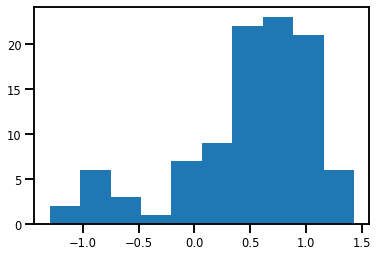

In [3]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

## Data

<Figure size 432x288 with 0 Axes>

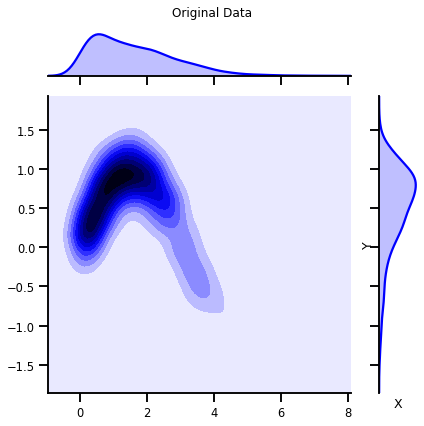

In [237]:
# %%wandb
# get data
n_samples = 1_000
n_features = 1
data = get_classic(n_samples)

# plot data
plot_joint(data, "blue", "Original Data", logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

<AxesSubplot:>

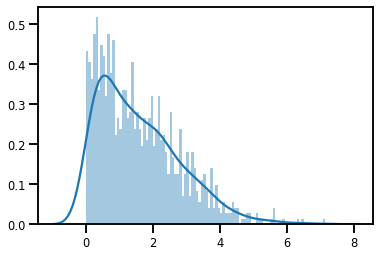

In [238]:
X = np.array(data[:, 0], dtype=np.float32)

sns.distplot(X, bins=100)

## State Variables

In [239]:
import collections
TransformState = collections.namedtuple(
    "TransformState", ["X", "ldj", "info_reduction"]
)

## Histogram Uniformization

#### Parameters

In [240]:
import chex

@chex.dataclass
class UniHistParams:
    support: chex.ArrayDevice
    quantiles: chex.ArrayDevice
    support_pdf: chex.ArrayDevice
    empirical_pdf: chex.ArrayDevice

#### Function

In [241]:
from typing import Union
from rbig_jax.utils import get_domain_extension


def univariate_histogram(
    n_samples: int, 
    nbins: int, 
    support_extension: Union[int, float]=10,
    precision: int = 1_000,
    alpha: float = 1e-5
):
    
    
    # TODO a bin initialization function
    
    def init_fun(inputs):

        # get histogram counts and bin edges
        counts, bin_edges = np.histogram(inputs, bins=nbins)

        # add regularization
        counts = np.array(counts) + alpha

        # get bin centers and sizes
        bin_centers = np.mean(np.vstack((bin_edges[0:-1], bin_edges[1:])), axis=0)
        bin_size = bin_edges[2] - bin_edges[1]

        # =================================
        # PDF Estimation
        # =================================
        # pdf support
        pdf_support = np.hstack(
            (bin_centers[0] - bin_size, bin_centers, bin_centers[-1] + bin_size)
        )
        # empirical PDF
        empirical_pdf = np.hstack((0.0, counts / (np.sum(counts) * bin_size), 0.0))

        # =================================
        # CDF Estimation
        # =================================
        c_sum = np.cumsum(counts)
        cdf = (1 - 1 / n_samples) * c_sum / n_samples

        incr_bin = bin_size / 2

        # ===============================
        # Extend CDF Support
        # ===============================
        lb, ub = get_domain_extension(inputs, support_extension)

        # get new bin edges
        new_bin_edges = np.hstack((lb, np.min(inputs), bin_centers + incr_bin, ub,))

        extended_cdf = np.hstack((0.0, 1.0 / n_samples, cdf, 1.0))

        new_support = np.linspace(new_bin_edges[0], new_bin_edges[-1], int(precision), dtype=inputs.dtype)

        uniform_cdf = jax.lax.cummax(
            np.interp(new_support, new_bin_edges, extended_cdf), axis=0
        )

        # Normalize CDF estimation
        uniform_cdf /= np.max(uniform_cdf)
    
        # initialize parameters
        params = UniHistParams(
            support=new_support,
            quantiles=uniform_cdf,
            support_pdf=pdf_support,
            empirical_pdf=empirical_pdf
        )
        
        # forward transformation
        outputs = np.interp(inputs, new_support, uniform_cdf)
        

        
        return outputs, params
    
    
    def forward_transform(params, inputs):

        return np.interp(inputs, params.support, params.quantiles)

    def gradient_transform(params, inputs):
        return np.interp(inputs, params.support_pdf, params.empirical_pdf)

    def inverse_transform(params, inputs):
        return np.interp(inputs, params.quantiles, params.support)
    
    
    return init_fun, forward_transform, gradient_transform, inverse_transform

In [242]:
# univariate normalization Gaussianization parameters
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X_marg.shape[0]))

# initialize histogram transformation
init_transform_func, forward_f, grad_f, inverse_f = univariate_histogram(
    n_samples=data.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

#### Initialize + Forward Transform

In [243]:
X_u, params = init_transform_func(X)

<AxesSubplot:>

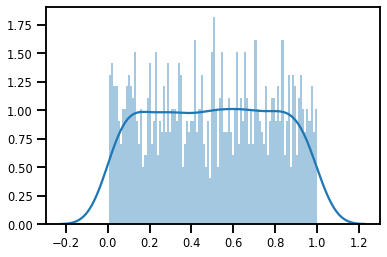

In [244]:
sns.distplot(X_u, bins=100)

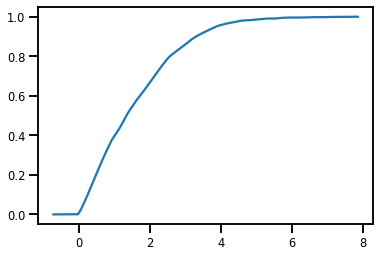

In [245]:
plt.plot(params.support, params.quantiles)

#### JIT

In [232]:
# JIT Compile (OPTIONAL)
init_f_jitted = jax.jit(init_transform_func)

In [233]:
X_u, hist_params = init_transform_func(X) 
%timeit init_transform_func(X.block_until_ready())
%timeit init_f_jitted(X.block_until_ready()) 

64.2 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
196 µs ± 50.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Forward Transformation

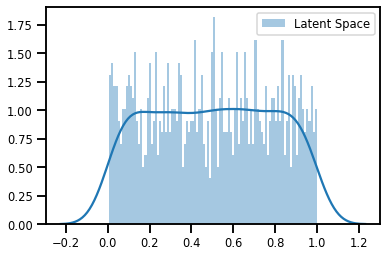

In [246]:
X_u = forward_f(params, X)

sns.distplot(X_u, bins=100, label="Latent Space")
plt.legend()

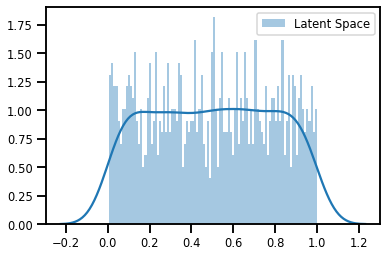

In [248]:
sns.distplot(X_u, bins=100, label="Latent Space")
plt.legend()

### Inverse Transformation

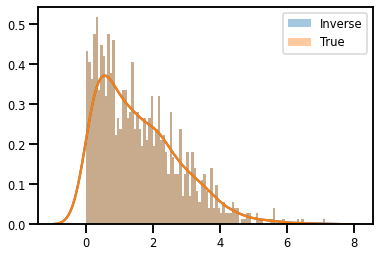

In [249]:
X_approx = inverse_f(params, X_u)


sns.distplot(X_approx, bins=100, label="Inverse")
sns.distplot(X, bins=100, label="True")
plt.legend()

### Jacobian

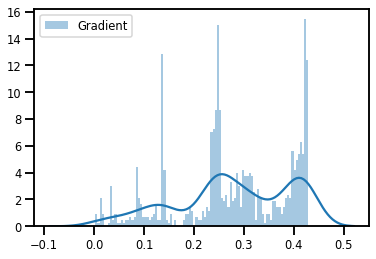

In [250]:
X_grad = grad_f(params, X)


plt.figure()
sns.distplot(X_grad, bins=100, label="Gradient")
plt.legend()
plt.show()

## Inverse CDF Estimation

In [251]:



def inverse_gauss_cdf(eps: float = 1e-5):
    
    # TODO a bin initialization function
    params = ()
    
    def init_func(inputs):
        
        inputs = np.clip(inputs, eps, 1 - eps)
        
        # forward transformation
        outputs = jax.scipy.stats.norm.ppf(inputs)
        
        
        return outputs, params
    
    def transform(params, inputs):
        
        inputs = np.clip(inputs, eps, 1 - eps)

        return jax.scipy.stats.norm.ppf(inputs)

    def gradient_transform(params, inputs):
        
        inputs = np.clip(inputs, eps, 1 - eps)

        outputs = jax.scipy.stats.norm.ppf(inputs)
        
        logabsdet = -jax.scipy.stats.norm.logpdf(outputs)

        return outputs, logabsdet

    def inverse_transform(params, inputs):
        
        return jax.scipy.stats.norm.cdf(inputs)
        
    
    return init_func, transform, gradient_transform, inverse_transform

### Forward Transform

In [252]:
# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
init_transform_func, forward_f, grad_f, inverse_f = inverse_gauss_cdf(eps=eps)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


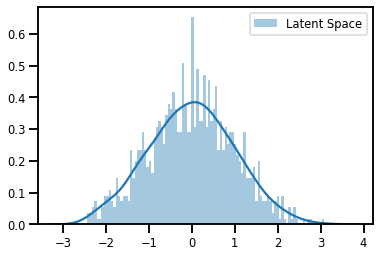

In [253]:
X_g, params = init_transform_func(X_u)

plt.figure()
sns.distplot(X_g, bins=100, label="Latent Space")
plt.legend()
plt.show()

### Inverse Transform

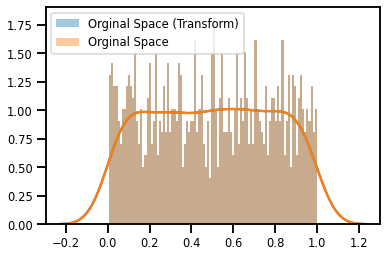

In [254]:
X_u_approx = inverse_f(params, X_g)

plt.figure()
sns.distplot(X_u_approx, bins=100, label="Orginal Space (Transform)")
sns.distplot(X_u, bins=100, label="Orginal Space")
plt.legend()
plt.show()

## Univariate Gaussianization

In [330]:
from typing import Union, Callable
from rbig_jax.utils import get_domain_extension

import chex

@chex.dataclass
class UniGaussParams:
    support: chex.ArrayDevice
    quantiles: chex.ArrayDevice
    support_pdf: chex.ArrayDevice
    empirical_pdf: chex.ArrayDevice

def univariate_gaussianization(
    uni_uniformize: Callable,
    eps: float = 1e-5
):
    # unpack functions
    uni_init_f, uni_forward_f, uni_grad_f, uni_inverse_f = uni_uniformize
    
    # TODO a bin initialization function
    def init_func(inputs):
        
        outputs, params = uni_init_f(inputs)
        
        outputs = np.clip(outputs, eps, 1 - eps)
        
        # forward transformation
        outputs = jax.scipy.stats.norm.ppf(outputs)
        
        return outputs, params
    
    def transform(params, inputs):
        
        inputs = uni_forward_f(params, inputs)
        
        inputs = np.clip(inputs, eps, 1 - eps)

        return jax.scipy.stats.norm.ppf(inputs)

    def gradient_transform(params, inputs):
        
        # Log PDF of normalized data
        logabsdet = np.log(uni_grad_f(params, inputs))
        
        # forward uniformization function
        outputs = uni_forward_f(params, inputs)
        
        # clip boundaries
        outputs = np.clip(outputs, eps, 1 - eps)
        
        # inverse cdf
        outputs = jax.scipy.stats.norm.ppf(outputs)
        
        # Log PDF for Gaussianized data
        logabsdet =  logabsdet - jax.scipy.stats.norm.logpdf(outputs)

        return outputs, logabsdet

    def inverse_transform(params, inputs):
        
        inputs = jax.scipy.stats.norm.cdf(inputs)
        
        outputs = uni_inverse_f(params, inputs)
        
        return outputs
        
    
    return init_func, transform, gradient_transform, inverse_transform

In [331]:
uni_uniformize = univariate_histogram(
        n_samples=data.shape[0],
        nbins=nbins,
        support_extension=support_extension,
        precision=precision,
        alpha=alpha
    )

eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = univariate_gaussianization(uni_uniformize, eps)

### Fit Transform

In [332]:
X_g, params = fit_transform_func(X)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


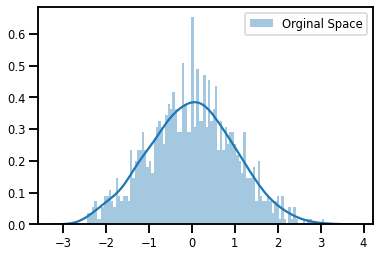

In [333]:
plt.figure()
sns.distplot(X_g, bins=100, label="Orginal Space")
plt.legend()
plt.show()

#### Jitted

In [343]:
fit_transform_func_jitted = jax.jit(fit_transform_func)

In [344]:
_ = fit_transform_func_jitted(X) 
%timeit fit_transform_func(X.block_until_ready())
%timeit fit_transform_func_jitted(X.block_until_ready()) 

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


93.8 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
163 µs ± 2.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Forward Transform

In [334]:
X_g = forward_f(params, X)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


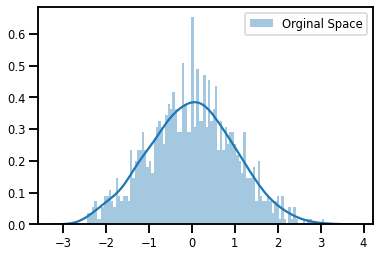

In [335]:
plt.figure()
sns.distplot(X_g, bins=100, label="Orginal Space")
plt.legend()
plt.show()

### Inverse Transform

In [336]:
X_approx = inverse_f(params, X_g)

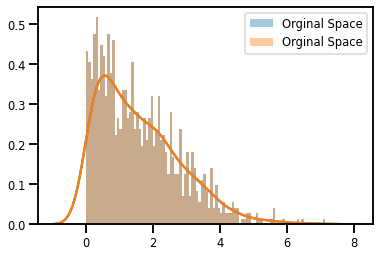

In [337]:
plt.figure()
sns.distplot(X_approx, bins=100, label="Orginal Space")
sns.distplot(X, bins=100, label="Orginal Space")
plt.legend()
plt.show()

### Gradient Transform

In [338]:
X_g, X_ldj = grad_f(params, X)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


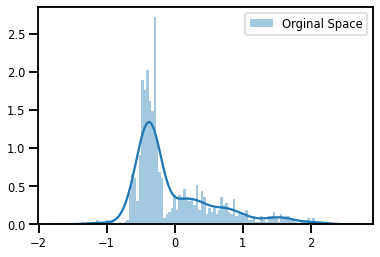

In [340]:
plt.figure()
sns.distplot(X_ldj, bins=100, label="Orginal Space")
plt.legend()
plt.show()

## Iterative Gaussianization

In [341]:
transforms = [
    # univariate transformation
    univariate_histogram(
        n_samples=data.shape[0],
        nbins=nbins,
        support_extension=support_extension,
        precision=precision,
        alpha=alpha
    ),
    # inverse Gaussianization Transformation
    inverse_gauss_cdf(eps=eps),
    ]


seq_model = SequentialTransform(transforms)

In [287]:
X_g, params = seq_model.fit_transform(X)

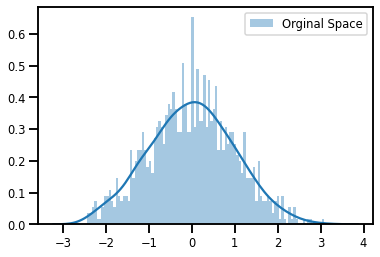

In [282]:
plt.figure()
sns.distplot(X_g, bins=100, label="Orginal Space")
plt.legend()
plt.show()

In [20]:
from rbig_jax.transforms.gaussianize import (
    gaussianize_forward, 
    gaussianize_inverse, 
    gaussianize_transform,
    get_gauss_params_hist
)

In [21]:
# marginal Gaussianization parameters
support_extension = 10
alpha = 1e-5
precision = 1_000

# create marginal transformation function (HISTOGRAM)
histogram_uniformize = jax.partial(
    get_hist_params, 
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# JIT Compile (OPTIONAL)
histogram_uniformize = jax.jit(histogram_uniformize)

In [22]:
from typing import Callable

def uni_gaussianize(
    X: np.ndarray, 
    uni_transform_f: Callable):
    
    # forward uniformization function
    X, params = uni_transform_f(X)
    # clip boundaries
    X = np.clip(X, 1e-5, 1.0 - 1e-5)

    # inverse cdf
    X = invgausscdf_forward_transform(X)

    return X, params



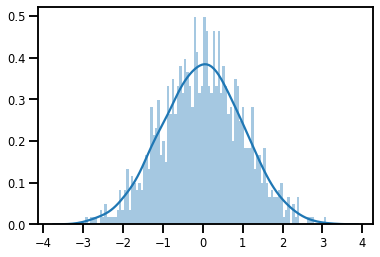

In [23]:
X_g, gauss_params = uni_gaussianize(X_marg, histogram_uniformize_jitted)

plt.figure()
sns.distplot(X_g, bins=100, label="Latent Space")
plt.show()

#### Forward Transformation

In [24]:
UniParams = collections.namedtuple(
    "UniParams", ["support", "quantiles", "support_pdf", "empirical_pdf"]
)

def uniformize_transform(X: np.ndarray, params: UniParams) -> np.ndarray:
    """Forward univariate uniformize transformation
    
    Parameters
    ----------
    X : np.ndarray
        The univariate data to be transformed.
    
    params: UniParams
        the tuple containing the params. 
        See `rbig_jax.transforms.uniformize` for details.
    
    Returns
    -------
    X_trans : np.ndarray
        The transformed univariate parameters
    """
    return np.interp(X, params.support, params.quantiles)


def uni_gaussianize_transform(
    X: np.ndarray, params, return_jacobian=True
):
    
    # forward uniformization function
    X = uniformize_transform(X, params)
    
    # clip boundaries
    X = np.clip(X, 1e-5, 1.0 - 1e-5)

    # inverse cdf
    X = invgausscdf_forward_transform(X)
    
    return X

        
        

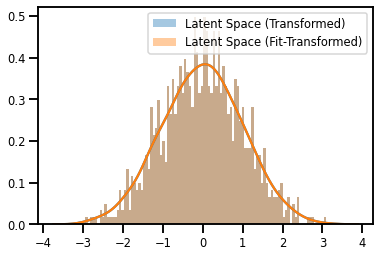

In [25]:
X_g_trans = uni_gaussianize_transform(X_marg, gauss_params)

plt.figure()
sns.distplot(X_g_trans, bins=100, label="Latent Space (Transformed)")
sns.distplot(X_g, bins=100, label="Latent Space (Fit-Transformed)")
plt.legend()
plt.show()

#### JIT

In [26]:
# compile the function to be faster
uni_gaussianization_transform_jitted = jax.jit(uni_gaussianize_transform)